<a href="https://colab.research.google.com/github/ashishar/Perimeter-Institute-Mini-Course-Quantum-2024/blob/master/PI_QML_Tutorial_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quantum Machine Learning - Tutorial 2**
# **Introduction to QML and Variational Algorithms**

**Please do not modify this notebook. To work on the tutorial, create your own copy by going to File > Save a Copy in Drive**

Before doing anything, please **run the following cell to install PennyLane.**

In [ ]:
%%capture
!pip install pennylane

In this tutorial we will leverage quantum optimization techniques to perform Machine Learning tasks using quantum computers. We will also implement some well-known variational algorithms. You do not need to solve the entire tutorial in 1.5 hours. Choose the topics that you find will benefit your learning and interests the most.

First, let's import PennyLane and some other libraries. **Run the cell below.**

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
import random

## **1. Classification**

### **A. Variational Quantum Classifier**

To warm up, let us do a quick run-through of the example we saw in class about fitting the parity function. Try to go through this without looking at the lecture notes, but do so if you need a gentle nudge in the right direction.

Recall that our objective is to classify bitstrings for length four (e.g `[0,1,1,0]`). If they have an even number of `1`s, we assign them the value $1$, and otherwise, we assign the value $-1$.

Variational classifiers usually define a "layer" or "block", which is an
elementary circuit architecture that gets repeated to build the full
variational circuit. Our circuit layer will use four qubits, or wires, and consists of an
arbitrary rotation on every qubit, as well as a ring of CNOTs that
entangles each qubit with its neighbour. Borrowing from machine
learning, we call the parameters of the layer `weights`. Let's take a look on how this quantum circuit looks like:

<p align="center">
  <img width="50%" src="https://raw.githubusercontent.com/gmlejarza/Tutorials_Perimeter/main/images/layer_tutorial_vc.png" />
</p>

(i) Complete the `layer` circuit that implements the block shown above. The argument `layer_weights` is a $4\times 3$ matrix encoding the angles of the `qml.Rot` gates.

In [ ]:
def layer(layer_weights):
  # Put your code here
  # This function does not return anything

(ii) We also need a way to encode data bitstring inputs $x$ into the circuit, so that
the measured output depends on the inputs. The
quantum state $\psi$ after state preparation is a computational basis
state that has 1s where $x$ has 1s, for example

$$x = 0101 \rightarrow |\psi \rangle = |0101 \rangle .$$

The `pennylane.BasisState` function
provided by PennyLane is made to do just this. It expects `x` to be a
list of zeros and ones, i.e. `[0,1,0,1]`. Complete the `state_preparation` subcircuit below that encodes a bitstring into a 4-qubit computational basis state.

In [ ]:
def state_preparation(x):
  # put your code here
  # this function does not return anything

(iii) Now it's time to build the circuit we'll use classifier, which looks like this
<p align="center">
  <img width="50%" src="https://raw.githubusercontent.com/gmlejarza/Tutorials_Perimeter/main/images/full_circuit_tutorial_vc.png" />
</p>

Using the subcircuits you coded above, build the circuit in terms of `weights` and the number of `layers`. Here `weights` is an array of matrices of length equal to that of `layers`. Each matrix in `weights` encondes the rotation parameters in the rotation gates (see `layer_weights` in part (i)).

In [ ]:
dev = qml.device('default.qubit', wires = range(4))

@qml.qnode(dev)
def circuit(weights, x):
  # Put your code here
  # This function has to return the expectation value of the PauliZ operator on the first wire

Now, to define the classifier, we add a bias term (i.e. a constant term). **Run the cell below.**

In [ ]:
def variational_classifier(weights, bias, x):
  return circuit(weights, x) + bias

(iv) Now let's code the `square_loss` and `accuracy` functions in terms of the actual `labels` ($1$ or $-1$ according to the parity) and the `predictions` of our classifier. Write a `my_loss` function that computes how far the predictions are from the labels. You can use the `square_loss` we used in the lecture or do something else!

In [ ]:
def my_loss(labels, predictions):
  # Go nuts!

Now **run the cell below to define the accuracy function and cost functions**

In [ ]:
def accuracy(labels, predictions):

  loss = 0
  for l, p in zip(labels, predictions):
      if abs(l - p) < 1e-5:
          loss = loss + 1
  loss = loss / len(labels)

  return loss

def cost(weights, bias, X, Y):
  # Here X is the input data, and Y are the labels we already have in the data.
  predictions = [variational_classifier(weights, bias, x) for x in X]
  return my_loss(Y, predictions)

(v) Now it's time for classical optimization. We've written this for you because, realistically, this is code you would copy-paste from somewhere and then adapt it to your needs. Nevertheless, try to understand what it's doing!

Let's first load some data and see what it looks like. **Run the cell below.**

In [ ]:
data_train = np.array([[0, 0, 0, 1, 1],
[0, 0, 1, 0, 1],
[0, 1, 0, 0, 1],
[0, 1, 0, 1, 0],
[0, 1, 1, 0, 0],
[0, 1, 1, 1, 1],
[1, 0, 0, 0, 1],
[1, 0, 0, 1, 0],
[1, 0, 1, 1, 1],
[1, 1, 1, 1, 0]])

X = np.array(data_train[:, :-1])
Y = np.array(data_train[:, -1])
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

for x,y in zip(X, Y):
    print(f"x = {x}, y = {y}")

Now let's initialize values for the parameters and run the optimization routine. Note that in the `cost` function, `weight` and `bias` are trainable parameters, so they must be specified as an array with `requires_grad = True`.  `X` and `Y` are not (they are the data!) so we must write `requires_grad = False` (see above). **Run the cell below to train the parameters in your model.**

In [ ]:
# Initialize parameters randomly

np.random.seed(0)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

# Choose optimizer and batch size for training

opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

weights = weights_init
bias = bias_init

# Train the model
weights = weights_init
bias = bias_init
for it in range(100):

  # Update the weights by one optimizer step, using only a limited batch of data
  batch_index = np.random.randint(0, len(X), (batch_size,))
  X_batch = X[batch_index]
  Y_batch = Y[batch_index]
  weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

  # Compute accuracy
  predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

  current_cost = cost(weights, bias, X, Y)
  acc = accuracy(Y, predictions)

  print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

Hopefully you got a good accuracy and didn't botch the loss function! Now let's tests it on unseen data. **Run the cell below to test.**

In [ ]:
data_test = np.array([[0, 0, 0, 0, 0],
[0, 0, 1, 1, 0],
[1, 0, 1, 0, 0],
[1, 1, 1, 0, 1],
[1, 1, 0, 0, 0],
[1, 1, 0, 1, 1]])
X_test = np.array(data_test[:, :-1])
Y_test = np.array(data_test[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}

predictions_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")

acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)

### **B. Kernel methods**

In the lecture we talked the Support Vector Machine as a Kernel Method. This is a topic in Classical Machine Learning, so we will not go into the details. The important task that a quantum computer can do is build the kernel for us. Let's see how to do this using a quantum device.

**Note:** This problem follows [this PennyLane demo](https://pennylane.ai/qml/demos/tutorial_kernel_based_training/) closely. If you get stuck, take a sneak peek, but don't cheat too much 😉!

Let us consider a *quantum model* of the form

$$f(x) = \langle \phi(x) | \mathcal{M} | \phi(x)\rangle,$$

where $| \phi(x)\rangle$ is prepared by a fixed [embedding
circuit](https://pennylane.ai/qml/glossary/quantum_embedding.html) that
encodes data inputs $x$, and $\mathcal{M}$ is an arbitrary observable.
This model includes variational quantum machine learning models, since
the observable can effectively be implemented by a simple measurement
that is preceded by a variational circuit:
<p align="center">
  <img src="https://pennylane.ai/_images/quantum_model.png" />
</p>

For example, applying a circuit $G(\theta)$ and then measuring the
Pauli-Z observable $\sigma^0_z$ of the first qubit implements the
trainable measurement
$\mathcal{M}(\theta) = G^{\dagger}(\theta) \sigma^0_z G(\theta)$.

The main practical consequence of approaching quantum machine learning
with a kernel approach is that instead of training $f$ variationally, we
can often train an equivalent classical kernel method with a kernel
executed on a quantum device. This *quantum kernel* is given by the
mutual overlap of two data-encoding quantum states,

$$\kappa(x, x') = | \langle \phi(x') | \phi(x)\rangle|^2.$$

Kernel-based training therefore bypasses the processing and measurement
parts of common variational circuits, and only depends on the data
encoding.

If the loss function $L$ is the [hinge
loss](https://en.wikipedia.org/wiki/Hinge_loss), the kernel method
corresponds to a standard [support vector
machine](https://en.wikipedia.org/wiki/Support-vector_machine) (SVM) in
the sense of a maximum-margin classifier. Other convex loss functions
lead to more general variations of support vector machines.

(i) Let's first import a data set to work with. Since the performance of the
models is not the focus of this tutorial, we can just use the first two
classes of the famous [Iris data
set](https://en.wikipedia.org/wiki/Iris_flower_data_set). Dating back to
as far as 1936, this toy data set consists of 100 samples of four
features each, and gives rise to a very simple classification problem. **Run the cell below to import the Iris data.**

In [ ]:
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X, y = load_iris(return_X_y=True)

# pick inputs and labels from the first two classes only,
# corresponding to the first 100 samples
X = X[:100]
y = y[:100]

# scaling the inputs is important since the embedding we use is periodic
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# scaling the labels to -1, 1 is important for the SVM and the
# definition of a hinge loss
y_scaled = 2 * (y - 0.5)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled)
print(X[0])

(ii) We will use the [angle-embedding
template](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.templates.embeddings.AngleEmbedding.html)
which needs as many qubits as there are features. **Run the cell below.**


In [ ]:
n_qubits = len(X_train[0])

To implement the kernel, we can prepare the two states
$| \phi(x) \rangle$, $| \phi(x') \rangle$ on different sets of qubits
with angle-embedding routines $S(x), S(x')$, and measure their overlap. But, in fact, we only need half the qubits if we prepare
$| \phi(x)\rangle$ and then apply the inverse embedding with $x'$ on the
same qubits. We then measure the projector onto the initial state
$|0..0\rangle \langle 0..0|$.

<p align="center">
  <img src="https://pennylane.ai/_images/kernel_circuit.png" />
</p>


To verify that this gives us the kernel:

$$\begin{aligned}
\begin{align*}
    \langle 0..0 |S(x') S(x)^{\dagger} \mathcal{M} S(x')^{\dagger} S(x)  | 0..0\rangle &= \langle 0..0 |S(x') S(x)^{\dagger} |0..0\rangle \langle 0..0| S(x')^{\dagger} S(x)  | 0..0\rangle  \\
    &= |\langle 0..0| S(x')^{\dagger} S(x)  | 0..0\rangle |^2\\
    &= | \langle \phi(x') | \phi(x)\rangle|^2 \\
    &= \kappa(x, x').
\end{align*}
\end{aligned}$$

Note that a projector $|0..0 \rangle \langle 0..0|$ can be constructed
using the `qml.Hermitian` observable in PennyLane.

Let's now build the quantum kernel!

*Note:* You should probably need to use the functions `qml.AngleEmbedding` and `qml.adjoint`

In [ ]:
dev_kernel = qml.device("default.qubit", wires=n_qubits)

# build the projector here
projector=

@qml.qnode(dev_kernel)
def kernel(x1, x2):
    """The quantum kernel."""
    # put your code here

    # this function return the following
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

(iii) A good sanity check is whether evaluating the kernel of a data point and
itself returns 1. **Run an appropriate command in the cell below to verify that your kernel in fact satisfies this property.**


In [ ]:
# Run something here

(iv) The way an SVM with a custom kernel is implemented in scikit-learn
requires us to pass a function that computes a matrix of kernel
evaluations for samples in two different datasets A, B. If A=B, this is
the [Gram matrix](https://en.wikipedia.org/wiki/Gramian_matrix). **Complete the `kernel_matrix` function below to build this matrix of kernel evaluations.**


In [ ]:
def kernel_matrix(A, B):
    """Compute the matrix whose entries are the kernel
       evaluated on pairwise data from sets A and B."""
    return # Return the kernel matrix

(v) Training the SVM optimizes internal parameters that basically weigh
kernel functions. It is a breeze in scikit-learn, which is designed as a
high-level machine learning library. **Run the cell below to fit the Support Vector Machine**. (I'm aware this is kind of black-boxy, but if you're interested in how this work, do read up on *normal* Machine Learning. You will find that one is very black-boxy too though).


In [ ]:
svm = SVC(kernel=kernel_matrix).fit(X_train, y_train)

**Now run the cell below to compute the accuracy on the test set**


In [ ]:
with dev_kernel.tracker:
    predictions = svm.predict(X_test)
    accuracy=accuracy_score(predictions, y_test)
    print(accuracy)

(vi) The SVM predicted all test points correctly. How many times was the
quantum device evaluated? Can you make sense of this number? **Run the command below and then figure out where this number comes from.** *Hint: what it the size of the training set?*


In [ ]:
dev_kernel.tracker.totals['executions']

*Write here where this number comes from.*

(vii) What is the size of the testing set? With this number at hand, how many executions of the circuit will we need in total for both training and testing?


*Write the total number of executions here*

## **2. Variational Algorithms**

### **A. The Variational Quantum Eigensolver (VQE)**

The VQE algorithm is the bread and butter of Quantum Chemistry, since it allows us to find a more precise ground state for systems than we can do classically. Let's do this for an Ising Chain!

Consider a spin chain contains particles of spin $1/2$ in each of its $N$ sites. The spins may be pointing in the positive or negative $z$ direction, and we consider that there may be an external magnetic field acting on the system.  

Such a quantum system is described by the *Transverse Ising Hamiltonian*. For closed spin chain with a transverse magnetic field of intensity $h$, the Transverse Ising Hamiltonian reads

$$
H = -\sum_{i=1}^{N}Z_{i}\otimes Z_{i+1} - h\sum_{i}^{N}X_{i}.
$$

The subindices $i$ indicate the spin site  where the operators act. In a closed spin chain, we identify site $N+1$ with the first site.

(i) Build the Hamiltonian above using PennyLane for $N=4$ as a function of $h$.

In [ ]:
def create_Hamiltonian(h):

  # Your code here

  # Return the PennyLane Hamiltonian for the Transverse Ising model

(ii) Write the QNode `model` that builds a general enough ansatz for the ground state. This means you want it to generate a superposition of all possible ground states! For each site $\vert 0 \rangle$ means spin down, and $\vert 1 \rangle$ means spin up This circuit must depend on some parameters `params`, which you will later optimize. It returns the expectation value of the Hamiltonian for the output state of the circuit.

In [ ]:
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev)
def model(params, h):

  # Write your circuit here

  # Return the expectation value of the Hamiltonian in terms of the field intensity h

(iii) At this point you should be proficient enough to figure out the optimization yourself! Copy-paste some optimization routine you think would be useful for this problem (look at tutorial 1, for example), define your cost function, and find the ground state and energy of the Hamiltonian!

In [ ]:
# Your optimization routine here

### **B. The Quantum Approximate Optimization Algorithm**

The QAOA algorithms is useful to solve Combinatorial Optimization Problems. In this exercise we will use it to solve the Minimum vertex cover problem, in which one must find the minimum number of vertices such that all chosen vertices are adjacent to one edge.

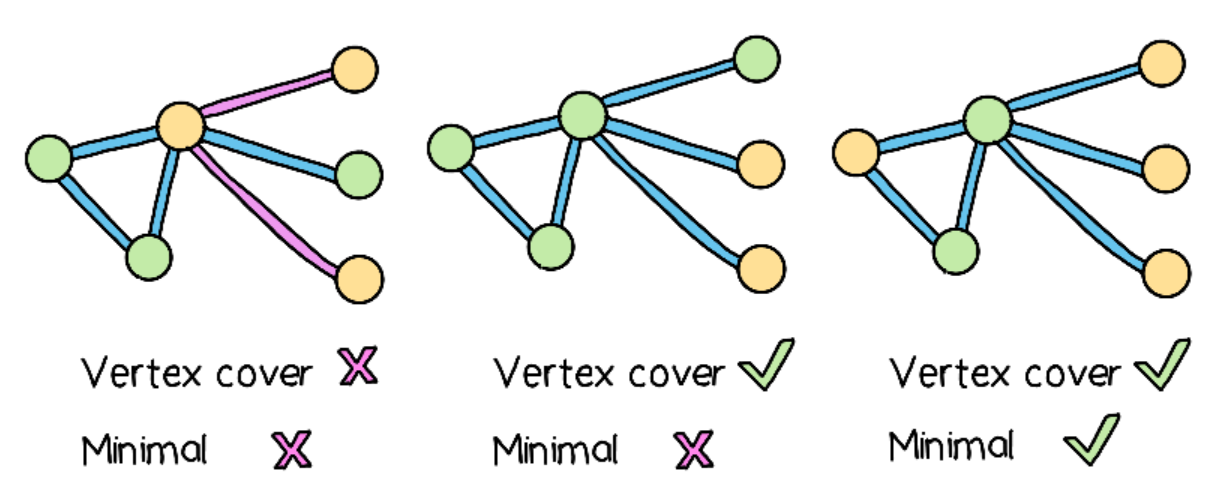

(i) Using the `networkx` library, create the following graph by specifying the edges:

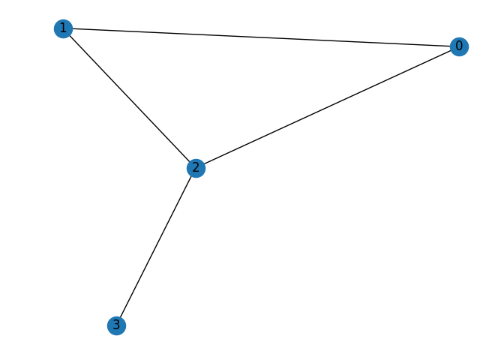

In [ ]:
import networkx as nx
edges = # Put the edges here
graph = nx.Graph(edges)

(ii) Now we will import the `cost_hamiltonian` and `mixer_hamiltonian` for this problem. Using these, write the QAOA circuit. Here `params` is a list of pairs corresponding to coefficients of the cost and mixer hamiltonians in each layer. The length of `params` is equal to the number of layers.

In [ ]:

num_wires = 4
cost_hamiltonian, mixer_hamiltonian = qml.qaoa.min_vertex_cover(graph, constrained=False)

dev = qml.device('default.qubit', wires = num_wires)

@qml.qnode(dev)
def qaoa_circuit(params):

    # Write your circuit here

    return # Return the cost Hamiltonian

(iii) Now write the optimization routine to find the parameters that minimize the expectation value of the cost Hamiltonian.

In [ ]:
def optimization(): # You can add arguments here if you need them


  #Your optimization routine here


(iv) Paste your previous circuit to return the probabilities for the optimal parameters

In [ ]:
dev = qml.device('default.qubit', wires = num_wires)

@qml.qnode(dev)
def qaoa_probs(params):

    # Paste your previous circuit here

    return qml.probs(range(num_wires))

In [ ]:
probs = # Evaluate qaoa_probs in the optimal parameters

tensor([0.00126966, 0.02278572, 0.02097874, 0.031067  , 0.00885351,
        0.01361173, 0.23369997, 0.01671588, 0.00885351, 0.01361173,
        0.23369997, 0.01671588, 0.06457311, 0.13417087, 0.12741598,
        0.05197673], requires_grad=True)

(v) Plot the probabilities and see if the answer matches what you expected! **Run the cell below**

In [ ]:
from matplotlib import pyplot as plt
plt.style.use("seaborn")
plt.bar(range(2 ** 5), probs)
plt.show()